In [1]:
%matplotlib inline
import os
import itertools
import json
import numpy as np
from matplotlib import pyplot as plt
from morty.extras.foldgenerator import FoldGenerator
from dlfm_code.tester import plot_min_peak_ratio


In [2]:
# ipyparallel
import ipyparallel

# get the clients
clients = ipyparallel.Client()
print(clients.ids)

# create a direct view into the engines
dview = clients.direct_view()

with dview.sync_imports():
    from dlfm_code.trainer import compute_recording_distributions
    from dlfm_code.trainer import train_single
    from dlfm_code.trainer import train_multi 
    from dlfm_code.tester import search_min_peak_ratio
    

[0, 1, 2, 3, 4, 5, 6, 7]
importing compute_recording_distributions from dlfm_code.trainer on engine(s)
importing train_single from dlfm_code.trainer on engine(s)
importing train_multi from dlfm_code.trainer on engine(s)
importing search_min_peak_ratio from dlfm_code.tester on engine(s)


In [3]:
# paths
dataset_path = os.path.abspath(os.path.join(
        './', 'data', 'ottoman_turkish_makam_recognition_dataset'))

# parameters
distribution_types = ['pd', 'pcd']
step_sizes = [7.5, 15.0, 25.0, 50.0, 100.0]
kernel_widths = [0, 7.5, 15.0, 25.0, 50.0, 100.0]
model_types = ['single', 'multi']
min_peak_ratios = np.arange(0, 1.01, 0.05).tolist()

# load annotation
annotations = json.load(open(os.path.join(dataset_path, 'annotations.json')))

# ipyparallel executes the code in where the engines have started
# add the absolute repository directory to annotation
for a in annotations:
    a['dataset_path'] = dataset_path


## Select min_peak_ratio
This parameter is used in tonic identification and joint estimation to consider the minimum peak height wrt the highest peak. 

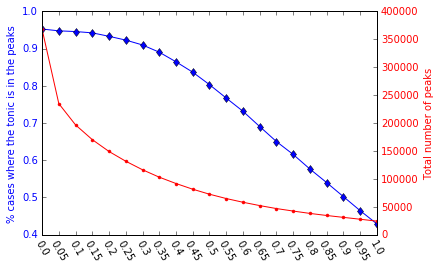

In [6]:
# get all the combinations for 
pcombs = list(
    itertools.product([7.5, 15.0], kernel_widths, distribution_types, min_peak_ratios))
# ignore combinations in which kernel_width is three times less than the step_size
pcombs = [c for c in pcombs if c[1] == 0 or 3 * c[1] >= c[0]]
pcombs = np.array(pcombs, dtype='object').transpose().tolist()

# get the number of recordings where the tonic is among the peaks vs.
# the total number of peaks for each experiment
tmp_peak = dview.map_sync(search_min_peak_ratio, *pcombs)

# accumulate the numbers
num_tonic = np.zeros(len(min_peak_ratios))
num_peak = np.zeros(len(min_peak_ratios))
for i, (t, p) in enumerate(tmp_peak):
    # print '%d, %d, %.2f' %(t, p, pcombs[-1][i])
    idx = np.where(np.isclose(min_peak_ratios, pcombs[-1][i]))
    num_tonic[idx] += t
    num_peak[idx] += p
per_tonic = num_tonic / (1000.0 * len(pcombs[-1]) / len(min_peak_ratios))    

# plot tonic percentage and number of peaks vs minimum peak ratio
plot_min_peak_ratio(min_peak_ratios, per_tonic, num_peak)

In [5]:
# testing parameters
dis_measure = ['l1', 'l2', 'l3', 'bhat', 'jeffrey', 'js',
               'dis_intersect', 'dis_corr']
k_neighbor = [1, 3, 5, 10, 15]
min_peak_ratio = [0.1]